# Constrainsts

In life you must set boundaries and in computational chemistry you can do the same thing. Let us investigate the consequences of changing the bong angle in water. We can easily obtain an optimized geometry but we want to force the bond angle into values outside of that perfect value. Its easy to role to the bottom of an energy well but how do we cling to its steep slope? We must set anchors. In this case we will set constrainsts.

## Optimize Bond Angle in Water

First we will optimize the geometry of water as we have done in the previous exercise. We will set up the structure using a Z-matrix as that is the easiest way to access a bond angle. The Z-matrix set that angle when we built the geomtry in the first place. So let us repeat the optimization from the previous notebook.

In [1]:
# use psi4conda environment
import psi4
import os
import numpy as np
import helpers as hp # Many useful functions from https://lcbc-epfl.github.io/iesm-public/intro.html

output_file = "H2O_constrainst_1.out"
psi4.set_memory("1GB")
psi4.set_output_file(output_file, append=False, loglevel=20, print_header=True, inherit_loglevel=True, execute=True)
psi4.core.set_num_threads(4)

# The Z-matrix as a text string
data = """
       0 1
       O1
       H2  1  length
       H3  1  length  2  angle
       length = 1.0
       angle = 110
       units angstrom
       """ 

# Create the Molecule object
mol = psi4.geometry(data)             # Create Molecule object from data string

psi4.core.clean_options()
psi4.set_options({
        "BASIS": "cc-pvdz",           # default => None - Basis set must be specified
        "SAVE_OPTIMIZATION": True,    # default => False
        "MAXITER": 100,               # default => 50
        "GEOM_MAXITER": 100,          # default => 50
        "FULL_HESS_EVERY": 5,         # default => -1
        "PRINT": 2,                   # default => 1
        "GUESS": "sad",               # default => auto
        "REFERENCE": "rhf",           # default => rhf
        "SCF_TYPE": "direct",         # default => pk
        "INTS_TOLERANCE": 1E-8        # default => 1e-12. A value of 1e-8 is recommended when SCF_TYPE set to "direct"
    })

start_angle = mol.get_variable("angle")
start_length = mol.get_variable("length")
print(f"Before optimization: {start_angle:.3f} degrees and {start_length:.3f} angstroms\n") 


opt_energy, hist = psi4.optimize("hf", molecule = mol, return_history=True)
print(f"The optimized energy for this configuration is {opt_energy:.7f} Hartree\n")

mol.print_out()
mol.print_distances()
mol.print_bond_angles()
mol.print_in_input_format()

opt_angle = mol.get_variable("angle")
opt_length = mol.get_variable("length")

print(f"After optimization: {opt_angle:.3f} degrees and {opt_length:.3f} angstroms\n") 

hp.drawXYZ(mol)  # This command form the 'helpers' library will display the molecule
                 # Does it look like what you expect?


  Memory set to 953.674 MiB by Python driver.
Before optimization: 110.000 degrees and 1.000 angstroms

Optimizer: Optimization complete!
The optimized energy for this configuration is -76.0270535 Hartree

After optimization: 104.617 degrees and 0.946 angstroms



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Changing a Variable

One way to investigate the effect of changing bond angle on energy would be to take this optimized structure and simply assign new bond angles and then calculate the energy. This is a simplistic approach becuase one knows that the bond length will change slightly with bond angle due to changes in hydridization (e.g., $sp^2$ bonds are shorter than $sp^3$ bonds.) However let us use this simple way to start.

### Scanning the Bond Angle

We have set up the geometry with a variable named "angle." That variable has been changed in the optimization but we can change it manually using the ```.set_variable()``` method of the Molecule object. We will set the angle to whatever we want, then update the geomtry (recalculate the *xyz* cartesian coordinates with the new angle). After that we will calculate the energy of the new geometry. Rinse and repeat through a series of values.

Recall how we did this with *Gamess*. We took the inoput file that we had constructed using the optimized geometry and then used the awesome text tools of *Unix* to change the angle (*grep*, *sed* and *awk* are the secret underpinning of modern science.) Then we subitted a whole batch of input files with different bond angles into *Gamess* on-at-a-time using the batch-queueing program *GamessQ*. But with the power of *Python* we cane do all this inside this notebook. We are using *Psi4* because it has an *Python* API that can be imported and used in a notebook like this.

In the code below we pick values from a range of values and asign them in turn to the variable "angle." in each case we caluclate the energy and append that value to a list. After the series of calculations is complete we will have a list of angles and a list of energies.



In [2]:
output_file = "H2O_constrainst_2.out"
psi4.set_memory("1GB")
psi4.set_output_file(output_file, append=False, loglevel=20, print_header=True, inherit_loglevel=True, execute=True)
psi4.core.set_num_threads(4)

deviation = 10

start = opt_angle - deviation
end = opt_angle + deviation
number_of_points = 2 * deviation + 1
range_of_values = np.linspace(start, end, number_of_points) 

# We could also enter a set of values at which to to measure energies. try the range below and
# observe the energy profile. Can you explain it?
#range_of_values = [75,90,100,105,110,120,130,140,150,160,170,175,180,185,190,200,220,230,] 
range_of_values = [90,105,120,178] 

angle_list = []
energy_list = []
length_list = []


for angle in range_of_values:
    mol.set_variable("angle", angle)
    energy = psi4.energy("hf", molecule = mol)
    angle_list.append(angle)
    energy_list.append(energy)
    length_list.append(mol.get_variable("length"))

print(angle_list)
print(energy_list)
print(length_list)

[90, 105, 120, 178]
[-76.02069044209318, -76.02704932002146, -76.02118133390033, -75.97031252234643]
[0.9463613097709636, 0.9463613097709637, 0.9463613097709633, 0.9463613097709633]


## Data Handling

We just generated some data. List of numbers are kind of useless. We need to do some data manipulation.

A convenient tool for data handling is the *Pandas* library. It provides a powerful data object, the dataframe. We will combine the two lists into a dataframe. Then we will print the dataframe. We can output the dataframe as a csv file for future analysis. In many ways, we can manipulate a dataframe like a spreadsheet. Consider the code below.

In [3]:
import pandas as pd

data_dictionary = {"angle": angle_list,
                   "energy": energy_list}

df = pd.DataFrame.from_dict(data_dictionary)
#df.set_index('angle', inplace=True)
print(df.head())

   angle     energy
0     90 -76.020690
1    105 -76.027049
2    120 -76.021181
3    178 -75.970313


### Math with a Dataframe

Lets do some math. We know the optimized energy from previous calulations above. We will subtract this lowets energy value from the energy column of the dataframe. Then we will multiply this column of relative energy values by a conversion factor to get kJ/mole rather than Hartrees.

In [4]:
df["energy"] = df["energy"] - opt_energy
df["energy"] = df["energy"] * psi4.constants.hartree2kJmol

print(df.head())

   angle      energy
0     90   16.706204
1    105    0.010973
2    120   15.417368
3    178  148.973415


### A Quick Plot

The dataframe object is very powerful. It contains a method that will plot the data. In the example below, we set which columns were to be used in the x and y-axis of the plot. Does this look like a typical energy profile for a vibration? the angle decreasing and increasing on either side of the optimal value is just like a bending vibration.

<Axes: xlabel='angle'>

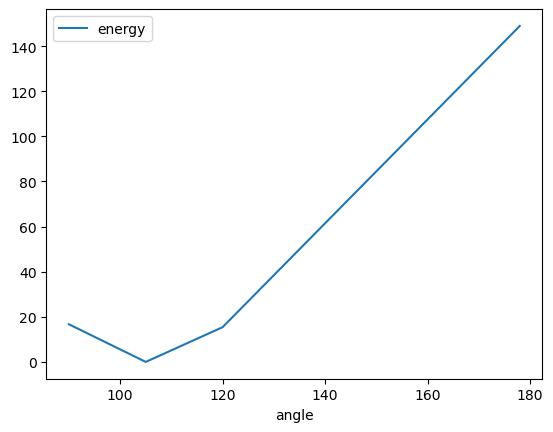

In [5]:
df.plot(x="angle", y = "energy", kind="line")   # try kind="scatter" as well

## A Relaxed Scan

The above scan of bond angles and energies was performed by merely setting the angle. This works well with a simple molecule like water, but in more complex cases we might be passing atoms through other atoms when we change a bond angle that moves a whole section of the molecule at the other end of that bond. *Psi4* is not built to model nuclear fusion. So be aware of that whenever chaning bond lengths, angles and torsions.

Even in a simple molecule we are not accounting for other changes that would occur when we change a parameter.  The O–H bond length will change slightly as we change bond angle. We are not actually at the lowest energy for a bond angle of 100 degrees unless we allow the bond lengths to "relax" and be optimized to the new values that result in the lowest energy for the case of that bond angle.

### Setting up Constraints

If you are familiar with *Gamess* you will know that there are several ways to contrain parameters in the geometry of a molecule. The same is true for *Psi4*. Here will will give you one example of a way to constrain a value.

In the list of options available to *Psi4* (which you can access with ```psi4.core.print_global_options()```) we see the following tempting values that can be set...

> FROZEN_DISTANCE<br>FROZEN_BEND<br>FROZEN_DIHEDRAL           

I think that ```FROZEN_BEND``` is the one we need. It will take a string of numbers in groups of three, one group for each frozen bend. But what numbers should we use. Let us examine the input string above (reproduced below).

> ```
O1
H2  1  length
H3  1  length  2  angle
length = 1.0
angle = 110 

We see that the atoms are numberes with the oxygen being atom \#1. The bend defined by the variable "angle" is the bend from atoms \#3 (hydrogen)through atom \#1 (oxygen) to atom \#2 (hydrogen). The command below will add the text string ```"3 1 2"``` to the ```FROZEN_BEND``` option (which is empty by default).


In [6]:
psi4.set_options({"FROZEN_BEND":"3 1 2"})


### Optimization with Constraints

Next we will perform the optimization of the water by setting the angle variable as above. this time rather than calculate the energy of the structiure as given, we will optimize using the new angle, which is frozen. All other parameters (in this case only the O–H bond lengths) will be allowed to optimize.

By setting a frozen variable and allowing all others to optimize, we are finding the "relaxed" structure for the given constraint.


In [7]:
output_file = "H2O_constrainst_3.out"
psi4.set_memory("1GB")
psi4.set_output_file(output_file, append=False, loglevel=20, print_header=True, inherit_loglevel=True, execute=True)
psi4.core.set_num_threads(4)

deviation = 10

start = opt_angle - deviation
end = opt_angle + deviation
number_of_points = 2 * deviation + 1
range_of_values = np.linspace(start, end, number_of_points) 

# We could also enter a set of values at which to to measure energies. try the range below and
# observe the energy profile. Can you explain it?
#range_of_values = [75,90,100,105,110,120,130,140,150,160,170,175,179,185,190,200,220,230,] 
#range_of_values = [90,105,120,178]   # Cant use a bend of 180 in a Z-matrix

angle_list = []
energy_list = []
length_list = []

psi4.set_options({"FROZEN_BEND":"3 1 2"})

for angle in range_of_values:
    
    print(f"3 1 2 angle is {angle}")
    mol.set_variable("angle", angle)     # variable "angle" is for the 3 1 2 bend in the Z-matrix
    
    energy = psi4.optimize("hf", molecule = mol)
    
    angle_list.append(mol.get_variable("angle"))
    energy_list.append(energy)
    length_list.append(mol.get_variable("length"))

print(angle_list)
print(energy_list)
print(length_list)

3 1 2 angle is 94.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 95.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 96.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 97.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 98.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 99.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 100.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 101.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 102.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 103.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 104.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 105.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 106.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 107.61673136612943
Optimizer: Optimization complete!
3 1 2 angle is 108.61673136612943
Optimizer: Optimizat

### More Data to Examine

Now let us examine the data from this calculation. We will plot the energy and also the bond distance as the angle changes. Examine the code below and follow it through to see how it works. Its all been cut and pasted from above with some changes made (we have three columns in our data now.)

         angle    energy    length
0    94.616731  7.500142  0.951303
1    95.616731  6.046260  0.950819
2    96.616731  4.754027  0.950265
3    97.616731  3.621580  0.949724
4    98.616731  2.647022  0.949196
5    99.616731  1.828388  0.948681
6   100.616731  1.163635  0.948179
7   101.616731  0.650648  0.947688
8   102.616731  0.287233  0.947209
9   103.616731  0.071120  0.946741
10  104.616731 -0.000034  0.946284
11  105.616731  0.071346  0.945837
12  106.616731  0.282763  0.945401
13  107.616731  0.631644  0.944975
14  108.616731  1.115337  0.944558
15  109.616731  1.731120  0.944150
16  110.616731  2.476196  0.943752
17  111.616731  3.347693  0.943362
18  112.616731  4.342670  0.942979
19  113.616731  5.458112  0.942605
20  114.616731  6.690937  0.942238


<Axes: xlabel='angle', ylabel='length'>

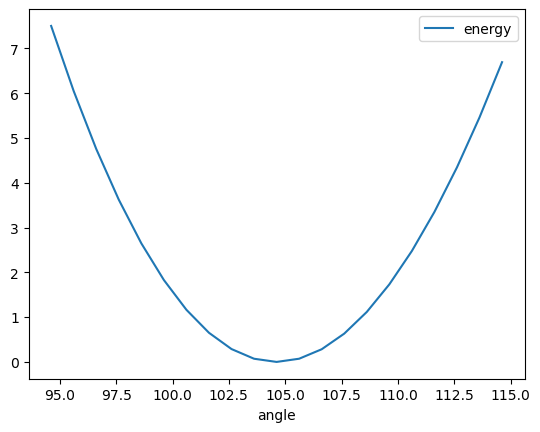

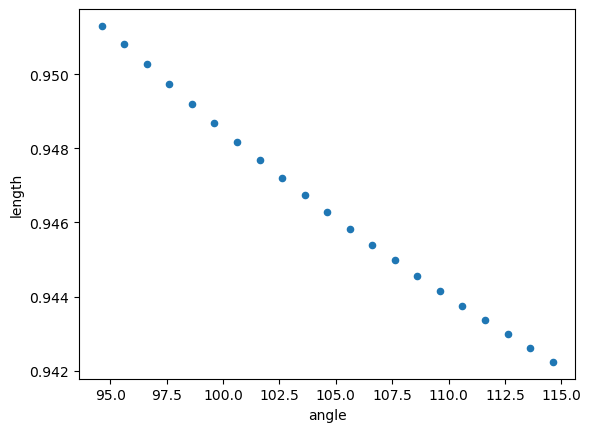

In [8]:
data_dictionary = {"angle": angle_list,
                   "energy": energy_list,
                   "length": length_list}

df = pd.DataFrame.from_dict(data_dictionary)

df["energy"] = df["energy"] - opt_energy
df["energy"] = df["energy"] * psi4.constants.hartree2kJmol

#df.set_index('angle', inplace=True)
print(df)

df.plot(x="angle", y = "energy", kind="line")   # try kind="scatter" as well
df.plot(x="angle", y = "length", kind="scatter")   # try kind="scatter" as well

## Conclusions

We surveyed the effect of changing the bend angle in water using single-point energy calculations of tsructures at various bend angles and using a relaxed scan of the same series of bend angles. 

In the relaxed scan we observed that the O–H bond length did change by about 1\% as the bend angle was changed between 95 degrees and 115 degrees. The relaxed energies were indeed measurably lower between the simpler single-point calculations and the relaxed scan. Try the series of angles that includes more extreme values and see how much the energies and bond lengths differ between single-point and relaxed scans.

## Exporting Data

As a final note, let us discuss exporting data. We have dataframes of our coordinate scans as we varied the bend angle in water in a series of singlepoint calculations and in a relaxed scan. We can expoert these data sets as a csv text file for later use.

The code below will create a csv file from whatever data is in the current dataframe named "df". We could then import that data into another program and make fancy plots or create data tables in your thesis. The next line in the code will read in a dataframe from a csv file. So the next program could be another python program.

In [9]:
df.to_csv("data_file_name.csv", index = False)
df2 = pd.read_csv("data_file_name.csv")

print(df2)

         angle    energy    length
0    94.616731  7.500142  0.951303
1    95.616731  6.046260  0.950819
2    96.616731  4.754027  0.950265
3    97.616731  3.621580  0.949724
4    98.616731  2.647022  0.949196
5    99.616731  1.828388  0.948681
6   100.616731  1.163635  0.948179
7   101.616731  0.650648  0.947688
8   102.616731  0.287233  0.947209
9   103.616731  0.071120  0.946741
10  104.616731 -0.000034  0.946284
11  105.616731  0.071346  0.945837
12  106.616731  0.282763  0.945401
13  107.616731  0.631644  0.944975
14  108.616731  1.115337  0.944558
15  109.616731  1.731120  0.944150
16  110.616731  2.476196  0.943752
17  111.616731  3.347693  0.943362
18  112.616731  4.342670  0.942979
19  113.616731  5.458112  0.942605
20  114.616731  6.690937  0.942238
